# Conditional Choice Probabilitiy Estimators in 5 Easy Steps!

## Author: Eric Schulman

The following guide demonstrates how to use conditional choice probability (CCP) estimators in Python. It was written in part as a homework for the University of Texas second year course in industrial organization. These estimators are the normal way to think about how the future influences decisions in industrial organization and related economic fields.

To demonstrate how to use (and implement) a CCP estimator, we recover parameters for the cost function in [Rust 1987](https://www.jstor.org/stable/1911259). Rust's paper considers the decision of a bus manager. The bus manager decides whether or not to replace bus engines for his fleet of buses in Madison, Wisconsion. Replacing the engine has a high cost in the present but letting the engine accumulate mileage makes the bus more likely to break down in the future. Our goal is estimating parameters that tell us the importance of mileage when the bus manager decides to replace the engines. The bus manager's problem is very general and has become the 'mascot' for dynamic decisions in industrial organization.

We could use a logit to predict the bus manager's decisions. However, Rust found that a model where agents considered the future predicted bus engine replacement decisions more accurately. To think about the future, Rust solved a dynamic program to calculate the expected value of 'yes' and 'no' based on the current mileage. Rust included this value function inside a logit. His estimation routine alternates between finding the Bellman operator's fixed point and estimating the logit with a maximum likelihood routine. This approach is called the nested fixed point algorithm (NFXP). Rust has code for solving this value function and estimate parameters in Gauss on his [website](https://editorialexpress.com/jrust/nfxp.html). Additionally, there are [tutorials](https://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/ddp_ex_rust96_py.ipynb) demonstrating how to find the fixed point of the Bellman operator in Python.

The more recent approach to predicting dynamic choices is called conditional choice probability (CCP) estimation. This approach works similar to Rust's assymptotically. However, it simplifies Rust's NFXP. Instead of embedding a value function into a logit, we start with a simple estimate of the choice probabilities and adjust this estimate to account for the future. Your initial estimate of the choice probabilities will provide an estimate of the value function. This estimated value function will help adjust the estimates of how mileage influences the replacement probability. This approach was first introduced to the literature in [Hotz Miller 1993](https://www.jstor.org/stable/2298122). The code and data I used for this guide from comes from Victor Aguirregabiria and Pedro Mira's [website](http://individual.utoronto.ca/vaguirre/wpapers/program_code_survey_joe_2008.html) accompanying their paper [Aguirregabiria Mira 2002](http://individual.utoronto.ca/vaguirre/wpapers/program_code_survey_joe_2008.html) (more on them later).

## Step 1: Pre-processing the data and structural constants

There are two important factors involved with setting up the data
1. First, we  must pick a discount factor. This is the most important aspect of the CCP estimator and distinguishes it from a logit. Implicitly, our choice is an assumption about the bus manager because nothing in the data tells us about agent's discount factor (for more about this see [Magnac Thesmar 2002](https://www.jstor.org/stable/2692293)). All we see are mileage and replacment decisions. Making this assumption better explains the data.

2. Calculating the value function involves framing the bus manager's problem as a Markov process. As a result, we discretize our continuous data on mileage to caclulate the value function for a given amount of mileage more easily.

In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d #pre written interpolation function
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats #for kernel function

In [2]:
#format the bus .dat from augirregabiria and mira's website
data = np.fromfile('bus1234.dat')
data = data.reshape(len(data)/6,6)
data = pd.DataFrame(data,columns=['id','group','year','month','replace','miles'])

#save to .csv
data.to_csv('bus1234.csv')

#divide by 1e6 (use the same scale are Rust and AM)
data['miles'] = (data['miles'])/1e6

#switch to date time for ease 
data['date'] = pd.to_datetime(data[['year', 'month']].assign(Day=1))
data = data[['id','group','date','replace','miles']]

#lag date
date_lag = data.copy()
date_lag['date'] = date_lag['date'] - pd.DateOffset(months=1)
data = data.merge(date_lag, how='left', on=['id','group','date'] , suffixes=('','_next'))
data = data.dropna()

print(data.max())

id                              162
group                        530875
date            1985-04-01 00:00:00
replace                           1
miles                      0.388254
replace_next                      1
miles_next                 0.388254
dtype: object


In [3]:
#constants
BETA = .9999
GAMMA = .5772 #euler's constant

#size of step in discretization
STEP = .002

#make states global variables
STATES = np.arange(data['miles'].min(),data['miles'].max() + STEP, STEP)

## Step 2: Calculating Choice Probabilities 'Non-Parametrically'

The next step in our CCP estimation involves estimating the probability of replacing the bus engine with as few assumptions as possible. In particular, calculating our value function requires two objects. 

1. The transition matrix $F(i)$ 
2. The conditional replacement probabilities $P$.

We estimate these probabilities using the same approach as Aguirregabiria and Mira. However, in principle we could experiment with other (consistent) methods.

### The Transition Matrix

We need the amount that each bus's mileage $x$ will increase depending on the engine replacement decision $i$. We can think about this as a $K \times K$ matrix, where $K$ is the number of states our discretized variable can take. The rows of the matrix refer to the current state $x_t$ and the columns are $x_{t+1}$. Let $F(i)$ be the transition matrix between states depending on the replacement decision $i$. We will learn this using the Gaussian kernel.

In [4]:
def miles_pdf(i_obs, x_obs, x_next):
    """estimation of mileage pdf following AM using the
    kernel function
    
    this corresponds to pdfdx in AM's code"""
    
    #figure out max number of steps
    dx = (1-i_obs)*(x_next - x_obs) + i_obs*x_next
    
    #number of 'transition' states
    dx_states = np.arange(dx.min(),dx.max() +STEP , STEP)
    
    #use kernel groups to make pdf
    kernel1 = stats.gaussian_kde(dx, bw_method='silverman')
    pdfdx = kernel1(dx_states)
    
    return np.array([pdfdx/pdfdx.sum()]).transpose()


MILES_PDF = miles_pdf(data['replace'], data['miles'], data['miles_next'])

In [5]:
def transition_1(i_obs, x_obs , x_next):
    """calculate transitions probabilities,
    non-parametrically
    
    this corresponds to fmat2 in AM's code"""
    
    #transitions when i=1
    pdfdx = miles_pdf(i_obs, x_obs, x_next).transpose()
    
    #zero probability of transitioning to large states
    zeros = np.zeros( (len(STATES),len(STATES)-pdfdx.shape[1]) )
    
    #transitioning to first state and 'jumping' dx states
    fmat1 = np.tile(pdfdx,(len(STATES),1))
    fmat1 = np.concatenate( (fmat1, zeros), axis=1 )

    return fmat1

FMAT1 = transition_1(data['replace'], data['miles'],data['miles_next'])

In [6]:
def transition_0(i_obs, x_obs, x_next):
    """calculate transitions probabilities,
    non-parametrically
    
    this corresponds to fmat1 in AM's code"""
    
    pdfdx = miles_pdf(i_obs, x_obs, x_next).transpose()
    
    #initialize fmat array, transitions when i=0
    end_zeros = np.zeros((1, len(STATES) - pdfdx.shape[1]))
    fmat0 = np.concatenate( (pdfdx, end_zeros), axis=1 )

    for row in range(1, len(STATES)):
        
        #this corresponds to colz i think
        cutoff = ( len(STATES) - row - pdfdx.shape[1] )
        
        #case 1 far enough from the 'end' of the matrix
        if cutoff >= 0:
            start_zeros = np.zeros((1,row))
            end_zeros = np.zeros((1, len(STATES) - pdfdx.shape[1] - row))
            fmat_new = np.concatenate( (start_zeros, pdfdx, end_zeros), axis=1 )
            fmat0 = np.concatenate((fmat0, fmat_new))
       
        #case 2, too far from the end and need to adjust probs
        else:
            pdf_adj = pdfdx[:,0:cutoff]
            pdf_adj = pdf_adj/pdf_adj.sum(axis=1)
            
            start_zeros = np.zeros((1,row))
            fmat_new = np.concatenate( (start_zeros, pdf_adj), axis=1 )
            fmat0 = np.concatenate((fmat0, fmat_new))
            
    return fmat0

FMAT0 = transition_0(data['replace'],data['miles'],data['miles_next'])

PR_TRANS = FMAT0, FMAT1

### Conditional Choice Probabilities

We also need the probability of engine replacement decision $i$ conditional on mileage $x$. Let $P$ be a $K \times 1$ vector with the probability of replacing the engine conditional on the mileage $x$. We will learn this using a logit.

In [7]:
def initial_pr(i_obs, x_obs, d=0):
    """initial the probability of view a given state following AM.
    just involves logit to predict
    
    Third arguement involves display"""
    
    X = np.array([x_obs, x_obs**2, x_obs**3]).transpose()
    X = sm.add_constant(X)
    
    model = sm.Logit(i_obs,X)
    fit = model.fit(disp=d)
    if d: print(fit.summary())
    
    x_states = np.array([STATES, STATES**2, STATES**3]).transpose()
    x_states = sm.add_constant(x_states)
    
    return fit.predict(x_states)

PR_OBS = initial_pr(data['replace'], data['miles'], d=1)

Optimization terminated successfully.
         Current function value: 0.036201
         Iterations 23
                           Logit Regression Results                           
Dep. Variable:                replace   No. Observations:                 8156
Model:                          Logit   Df Residuals:                     8152
Method:                           MLE   Df Model:                            3
Date:                Sun, 20 Jan 2019   Pseudo R-squ.:                  0.1671
Time:                        14:30:51   Log-Likelihood:                -295.26
converged:                       True   LL-Null:                       -354.51
                                        LLR p-value:                 1.623e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.3136      4.188     -4.134      0.000     -25.522      -9.105
x1           149.3089     56

## Step 3: Alternative Value Function Representation

Now that we have estimates of the transition matrices and and choice probabilities we can calculate the value function to learn the importance of mileage to the bus manager. 


### Assumptions

The key insight in Rust 1987 and [Pakes 1986](https://www.jstor.org/stable/1912835) is that agents with the same characteristics may make different decisions. In other words, the bus manager may make different decisions about two buses with the same mileage. To accomplish this, agents experience a shock $\epsilon$ each period based on unobserved costs. To make the problem analytically tractable, we usally make 2 important assumptions about $\epsilon$

1. That this shock follows an extreme value distribution (so, that the PDF and CDF have the same functional form). 
2. We also make the assumption that these shocks are effect decisions like random noise (conditional independece). In other words, the shocks do not systematically influence the mileage.

### Calculation

Using the cost function (whose parameters we want to learn), the transition matrices, and choice probabilities (which we estimated) we can now calculate the value function from Rust's paper.

$$V = [I_m - \beta( (1-P) * F(0) +  P * F(1)) ]^{-1} [(1-P)*(u(0,x;\theta) + \gamma -ln(1-P)) + P*( u(1,x;\theta) + \gamma -ln(P) ) ]$$

This corresponds to equation (8) in Aguirregabiria Mira 2002. You can find a formal derivation of this in Hotz Miller 1993 and Aguirregabira Mira's paper.

For the purposes of clarifying the formula to see how I implemented it.
* $*$ is the Hadamard produce (i.e. element wise).
* $u(i,x;\theta)$ is the payoff function. I implemented this function using a Python `lambda` expression so that the cost specification is flexible. This means that the routine for calculating the value function takes the cost function (and its parameters) as an argument. Generally speaking it has the form.

* Finally, note there is a slight abuse of notation going on. The dimensions of $F$ are $K \times K$ so I needed to tile the vector $P$ in order to take the element wise product.

In [8]:
def hm_value(params, cost, pr_obs, pr_trans):
    """calculate value function using hotz miller approach"""
    
    #set up matrices, transition is deterministic
    trans0, trans1 = pr_trans
    
    #calculate value function for all state
    pr_tile = np.tile( pr_obs.reshape( len(STATES) ,1), (1, len(STATES) ))
    
    denom = (np.identity( len(STATES) ) - BETA*(1-pr_tile)*trans0 - BETA*pr_tile*trans1)
    
    numer = ( (1-pr_obs)*(cost(params, STATES, 0) + GAMMA - np.log(1-pr_obs)) + 
                 pr_obs*(cost(params, STATES, 1) + GAMMA - np.log(pr_obs) ) )
    
    value = np.linalg.inv(denom).dot(numer)
    return value

## Step 4: (Psuedo) Maximum Likelihood Estimaton

With the value function we just calculated, we can adjust the likehood of replacing the engine at mileage $x$ with the following formula. It is very similiar to the logit we used before and produces a $K\times1$ vector with a probability of replacement in each state. Now, the replacement probability also depends on $\beta$ and future $x$'s. 

$$\psi(P ; \theta) = \dfrac{exp[u(1,x,\theta) + \beta F(1) V] }{exp[u(1,x,\theta) + \beta F(1) V] + exp[u(0,x,\theta) + \beta F(0) V] }$$ 

This corresponds to the $\Psi$ function in Aguirregabiria Mira 2002. They parametrize $\Psi$ using the extreme value distribution right below Proposition 3 in their paper.

Ultimately, we wanted to learn how mileage influences the bus manager's decision by estimating the parameters in the cost function $\theta$. To learn these parameters, we can maximize the value of this likehood $\psi$ 'adjusted' for the  value function we estimated. This differs from regular maximum likehood estimation. This approach 'cheated' by estimating the value ahead of time to make the routine run faster. By cheating we loose precision (efficiency) in our estimates. 

To do true maximum likelihood estimation, we must formally calculate the value function (instead of estimating it using the data). The most common approach for calculating the value functon involves repeatedly applying the Bellman operator to find the fixed point of the Bellman equation. Our method is quick and still fits the data more accurately than a regular logit.

In [9]:
def hm_prob(params, cost, pr_obs, pr_trans):
    """calculate psi (i.e. CCP likelihood) using 
    the value function from the hotz miller appraoch"""
    
    value = hm_value(params, cost, pr_obs, pr_trans)
    value = value - value.min() #subtract out smallest value
    trans0, trans1 = pr_trans
    
    delta1 = np.exp( cost(params, STATES, 1) + BETA*trans1.dot(value))
    delta0 = np.exp( cost(params, STATES, 0) + BETA*trans0.dot(value) )
    
    return delta1/(delta1+delta0)

In [10]:
class CCP(GenericLikelihoodModel):
    """class for estimating the values of R and theta
    using the CCP routine and the helper functions
    above"""
    
    def __init__(self, i, x, x_next, params, cost, **kwds):
        """initialize the class
        
        i - replacement decisions
        x - miles
        x_next - next periods miles
        params - names for cost function parameters
        cost - cost function specification, takes agruements (params, x, i) """
        
        super(CCP, self).__init__(i, x, **kwds)
        
        #data
        self.endog = i #these names don't work exactly
        self.exog = x #the idea is that x is mean indep of epsilon
        self.x_next = x_next
        
        #transitions
        self.pr_obs = initial_pr(i, x)
        self.trans =  transition_0(i,x,x_next), transition_1(i,x,x_next)
        
        #should probably make these class parameters
        self.num_states = ( x.max()/STEP).astype(int) + 2
        self.states = np.arange(x.min(),x.max() + STEP, STEP)
        
        #initial model fit
        self.cost = cost
        self.num_params = len(params)
        self.data.xnames =  params
        self.results = self.fit( start_params=np.ones(self.num_params) )
        
        
    def nloglikeobs(self, params, v=False):
        """psuedo log likelihood function for the CCP estimator"""
        
        # Input our data into the model
        i = self.endog
        x = (self.exog/STEP).astype(int)*STEP #discretized x
           
        #set up hm state pr
        prob = hm_prob(params, self.cost, self.pr_obs, self.trans).transpose()
        prob = interp1d(self.states, prob)
        prob = prob(x)
        
        log_likelihood = (1-i)*np.log(1-prob) + i*np.log(prob)
        
        return -log_likelihood.sum()
    
    
    def iterate(self, numiter):
        """iterate the Hotz Miller estimation procedure 'numiter' times"""
        i = 0
        while(i < numiter):
            #update pr_obs based on parameters
            self.pr_obs = hm_prob(self.results.params, self.cost, self.pr_obs, self.trans)
            
            #refit the model
            self.results = self.fit(start_params=np.ones(self.num_params))
            i = i +1

### Linear Costs

First we estimate the cost of additional mileage and the cost of replacing a new engine using a linear cost function specification. This means that the cost associated with driving a bus is directly proportional to its mileage. 

$$c(x;\theta) = \theta_1 x$$

Augirregabiria and Mira found the 'true' maximum likelihood estimates for these parameters in their paper which I included below for reference. Our CCP estimator preforms relatively well compared to these parameter estimates. 

|Parameter| MLE Estimate |
|--|--|
| $\theta_1$|-.58 |
|$RC$| -10.47|


In [14]:
#define cost functon using lambda expression
linear_cost = lambda params, x, i: (1-i)*x*params[i] + i*params[i]

linear_model = CCP(data['replace'], data['miles'], data['miles_next'], ['theta1','RC'], linear_cost)
print(linear_model.results.summary())

Optimization terminated successfully.
         Current function value: 0.036544
         Iterations: 63
         Function evaluations: 120
                                 CCP Results                                  
Dep. Variable:                replace   Log-Likelihood:                -298.05
Model:                            CCP   AIC:                             598.1
Method:            Maximum Likelihood   BIC:                             605.1
Date:                Sun, 20 Jan 2019                                         
Time:                        14:32:44                                         
No. Observations:                8156                                         
Df Residuals:                    8155                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

### Quadratic Costs

Rust wanted to demonstrate that a model where the Bus manager considered the future better fit the data. As a result, Rust gave a very flexible for his cost function. One aditional specification involves quadratic costs.

$$c(x;\theta) = \theta_1 x + \theta_2 x^2$$

In [16]:
quad_cost = lambda params, x, i: (1-i)*(x*params[0] + x**2*params[1]) + i*params[2]

quad_model = CCP(data['replace'], data['miles'], data['miles_next'], ['theta1','theta2', 'R'], quad_cost)
print(quad_model.results.summary())

Optimization terminated successfully.
         Current function value: 0.036261
         Iterations: 147
         Function evaluations: 260
                                 CCP Results                                  
Dep. Variable:                replace   Log-Likelihood:                -295.75
Model:                            CCP   AIC:                             593.5
Method:            Maximum Likelihood   BIC:                             600.5
Date:                Sun, 20 Jan 2019                                         
Time:                        14:33:04                                         
No. Observations:                8156                                         
Df Residuals:                    8155                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

### Comparing Cost Functions

When we compare the value of a given amount of mileage under both specifications side by side, we see that the change does not drastically change the value at a given mileage. Considering the limited data, we probably cannot learn the actual functional form for the cost function.

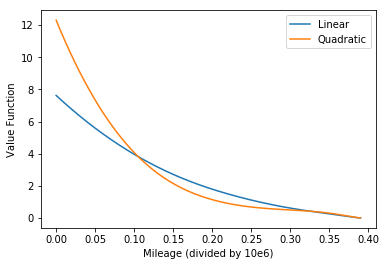

In [42]:
#set up plot of both value functions
fig = plt.figure()
v_linear = hm_value(linear_model.results.params, linear_model.cost, linear_model.pr_obs, linear_model.trans) 
v_linear = v_linear - v_linear.min() #normalize
v_quad = hm_value(quad_model.results.params, quad_model.cost, quad_model.pr_obs, quad_model.trans)
v_quad = v_quad - v_quad.min() #normalize

#make a plot of both value functions
plt.ylabel('Value Function')
plt.xlabel('Mileage (divided by 10e6)')
plt.plot(STATES,v_linear,label='Linear')
plt.plot(STATES,v_quad, label='Quadratic')

plt.legend()

## Step 5: Iterating the Model

Before we calculated $\psi(P;\theta)$ by estimating the probability of replacing the engine using a logit. The key to calculating  $\psi( \cdot ;\theta)$ is $P$. Our approach to estimating $P$ is very simple. So, you may wonder what happens if we use a better starting estimate of the choice probabilities? If we use a more precise $P$, Aguirregabiria and Mira showed that $\psi(P;\theta)$ will be more precise in their 2002 paper! 

Using better starting value like $\psi(P;\hat{\theta})$ guarantees that $\psi( \psi(P;\hat{\theta}); \theta)$ will be more precise. What's more, nothing is stopping you from repeating this process. After caclulating $\psi( \psi(P;\hat{\theta}); \theta)$, you can plug your estimate back into $\psi( \cdot ; \theta)$. In fact, if you keep iterating then you will converge to 'true' likelihood function estimates.

To demonstrate how this works, we iterate the CCP estimation procedure by repeatedly plugging the previous estimate of $\psi( \cdot ; \theta)$ into the likelhood function. We can see that the estimates get closer to Aguirregabiria and Mira's 'true' maximum likelihood estimates.

In [44]:
linear_model.iterate(2)
print(linear_model.results.summary())

Optimization terminated successfully.
         Current function value: 0.036528
         Iterations: 60
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 0.036528
         Iterations: 59
         Function evaluations: 114
                                 CCP Results                                  
Dep. Variable:                replace   Log-Likelihood:                -297.93
Model:                            CCP   AIC:                             597.9
Method:            Maximum Likelihood   BIC:                             604.9
Date:                Sun, 20 Jan 2019                                         
Time:                        14:42:52                                         
No. Observations:                8156                                         
Df Residuals:                    8155                                         
Df Model:                           0                                         
           